In [10]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import glob
import cv2
import csv
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [3]:
DATASET = 'data'
TESTING = '/workdir/test_imgs'

files = glob.glob('data/**/*.txt', recursive = True) #find all *.txt files

target_txt = "dataset_not_orig.txt"

In [4]:
train_df = pd.read_csv(target_txt, sep=',', header=None, names=['img_path', 'x0', 'y0', 'x1', 'y1', 'label'])
train_df.head()

,img_path,x0,y0,x1,y1,label
0,19-12-09_1652_624622812/000_03_04.png,463.0,204.0,560.0,241.0,2
1,19-12-09_1652_624622812/000_03_04.png,64.0,470.0,210.0,540.0,2
2,19-12-09_1652_624622812/000_03_04.png,267.0,464.0,332.0,535.0,1
3,19-12-09_1652_624622812/000_03_04.png,577.0,184.0,610.0,294.0,1
4,19-12-09_1652_624622812/000_03_04.png,346.0,268.0,421.0,366.0,1


In [5]:
train_df['img_path'].nunique()

771

In [6]:
train_df['label'].value_counts()

1    3568
2    1062
Name: label, dtype: int64

# TRAINING

In [7]:
#train shape
train_df.shape

#number of unique images
print(f"Unique images are {train_df['img_path'].nunique()}")

#number of images in dir
folder_images = []
for f in files:
  if "mask" not in f:
    folder_images.append(f)
print(f"Images in folder are {len(folder_images)}")

Unique images are 771
Images in folder are 12148


In [8]:
images_ids = train_df['img_path'].unique()

split_len = round(len(images_ids)*0.8) #80% -> train & 20% -> val

train_ids = images_ids[:split_len]
valid_ids = images_ids[split_len:]

train = train_df[train_df['img_path'].isin(train_ids)]
valid = train_df[train_df['img_path'].isin(train_ids)]

print(f"Train shape is {train.shape} and Validation shape is {valid.shape}")

Train shape is (3727, 6) and Validation shape is (3727, 6)


In [8]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

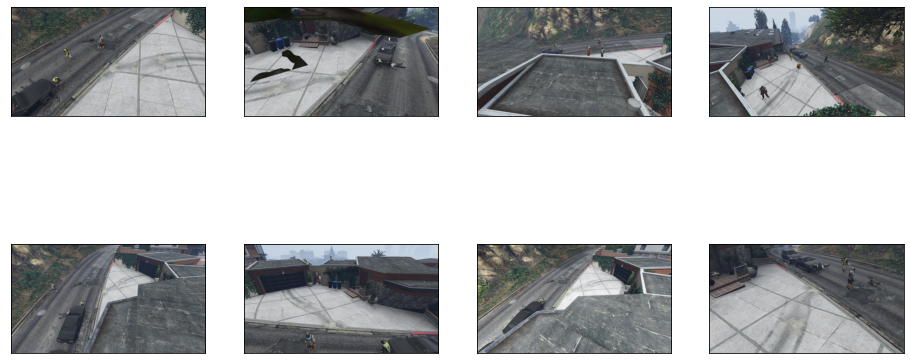

In [9]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{DATASET}/{n}') for n in train_df['img_path'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

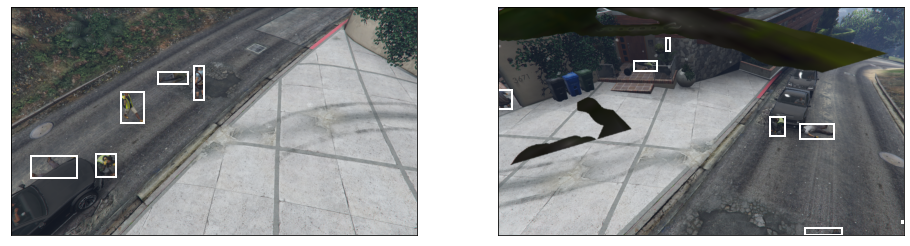

In [10]:
num_rows, num_cols = 1, 2
ids = train_df['img_path'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{DATASET}/{n}') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = train_df[train_df['img_path'] == id]
  bboxes = [(d['x0'], d['y0'], d['x1'], d['y1']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

In [9]:
class FallenPeople(Dataset):

    def __init__(self, dataframe, img_dir, transforms):
        super().__init__()
        self.image_ids = dataframe['img_path'].unique()
        self.df = dataframe
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df['img_path'] == image_id]

        image = cv2.imread(f'{DATASET}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x0', 'y0', 'x1', 'y1']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = records['label'].values
        labels = torch.as_tensor(labels, dtype = torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['img_path'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd

    #     if self.transforms is not None:
    #         sample = {'image': image, 'bboxes': target['boxes'], 'labels': labels}
    #         sample = self.transforms(**sample)
    #         image = sample['image']
    #         target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        if self.transforms is not None:
            image, target = self.transforms(image, target)


        return image, target, image_id

    def __len__(self) -> int:
        return len(self.image_ids)

In [11]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
train_dataset = FallenPeople(train, DATASET, get_transform(train=True))
valid_dataset = FallenPeople(valid, DATASET, get_transform(train=True))

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
56.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

74.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

94.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the c

In [14]:
print(model.roi_heads.box_predictor)

num_classes = 3 # fall or no fall or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)


In [15]:
def collate_fn(batch):
  return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

In [51]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# train it for 10 epochs
num_epochs = 10

In [24]:
# def train_model(model, train_data_loader, valid_data_loader, criterion, optimizer, num_epochs):
#     since = time.time()

#     val_acc_history = []

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)


# #train---------------------------------------------------------------
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0

#         for images, targets, image_ids in train_data_loader:    

#             images = list(image.to(device) for image in images)

#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  

#             optimizer.zero_grad()
# '''
#             loss_dict = model(images, targets)
          
#             losses = sum(loss for loss in loss_dict.values())
# '''
            
#             outputs = model(images)
#             labels = targets['labels']
#             loss = criterion(outputs, labels)
#             _, preds = torch.max(outputs, 1)
            
#             losses.backward()
#             optimizer.step()
          
#             losses_value = loss.item()

#             train_loss.append(losses_value)

#             epoch_train_loss = np.mean(train_loss)
#             total_train_loss.append(epoch_train_loss)


#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

# #valid--------------------------------------------------------------

#         with torch.no_grad():
#             valid_loss = []

#             model.eval()
#             running_loss = 0.0
#             running_corrects = 0

#             for images, targets, image_ids in valid_data_loader:
#                 images = list(image.to(device) for image in images)
#                 targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# '''
#                 loss_dict = model(images, targets)

#                 losses = sum(loss for loss in loss_dict.values())
#                 loss_value = losses.item()
#                 valid_loss.append(loss_value)
# '''
# #                 outputs = model(images)
# #                 labels = targets['labels']
# #                 loss = criterion(outputs, labels)
# #                 _, preds = torch.max(outputs, 1)

# #                 loss_value = loss.item()
# #                 valid_loss.append(loss_value)

# #                 epoch_valid_loss = np.mean(valid_loss)
# #                 total_valid_loss.append(epoch_valid_loss)

# #                 running_loss += loss.item() * inputs.size(0)
# #                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(valid_data_loader)
#             epoch_acc = running_corrects.double() / len(valid_data_loader)
#     print()    

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 53)

In [ ]:
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_ft, hist = train_model(model, train_data_loader, valid_data_loader, criterion, optimizer_ft, 2)

In [ ]:
'''
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
'''

In [52]:
#training funzionante
itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0.0

for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------
  running_corrects = 0

  model.train()
  train_loss = []
    
  for images, targets, image_ids in train_data_loader:    

    images = list(image.to(device) for image in images)

    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    print(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
    break
  
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()

  # valid ------------------------------

  with torch.no_grad():
    valid_loss = []
    model.eval()
    
    for images, targets, image_ids in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)
      print(loss_dict)
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
      prediction = model(images)
      print(prediction)
    
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)    
  
  # print ------------------------------

  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

RuntimeError: CUDA out of memory. Tried to allocate 252.00 MiB (GPU 0; 7.93 GiB total capacity; 6.80 GiB already allocated; 10.12 MiB free; 7.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

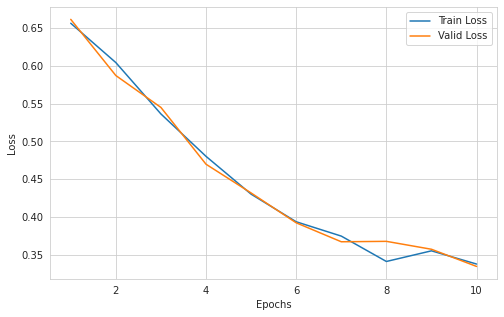

In [53]:
plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [54]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fallen_people_v1.pth')

In [ ]:
#QUESTA E' UNA PROVA